<a href="https://colab.research.google.com/github/subornaa/Data-Analytics-Tutorials/blob/main/CART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CART: Classification and Regression Trees

<img src = 'images/louppe_2014_decision_tree.png' width = 80%>

Image source: Louppe, Gilles. Understanding random forests: From theory to practice. Diss. Universite de Liege (Belgium), 2014.

# Introduction and Dataset

## Background

This tutorial provides an example of how to apply classification and regression trees (CARTs), specifically random forest (RF) to model tree species. Here we will approach this challenge in two ways 1) classifying dominant tree species; and 2) regressing tree species proportions.

Estimating dominant tree species is a common task in forestry that is often performed using remote sensing such as in Fancini et al. (2024).

[*Francini, Saverio, et al. "Forest species mapping and area proportion estimation combining Sentinel-2 harmonic predictors and national forest inventory data." International Journal of Applied Earth Observation and Geoinformation 131 (2024): 103935.*](https://doi.org/10.1016/j.jag.2024.103935)

## Tutorial goals

**Goal 1: Develop a random forest (RF) classification model to classify dominant tree species and tree type (coniferous vs. deciduous)**

**Goal 2: Create a new RF model that performs species proportion regression and compare this to the species classification model.**

**Goal 3: Perform feature selection using scikit-learn and remove correlated predictors**

**Goal 4: Experiment with different hyperparameters to limit overfitting**


-----

## Data

This tutorial makes use of light detection and ranging (LiDAR) metrics and multispectral indices that are derived in the Lasso and Ridge Regression Tutorial notebook. Specifically, the `predictors.csv` file generated contains all the predictor variables used in the current tutorial. Please refer to the Lasso and Ridge Regression tutorial for more information about how these metrics/indices were calculated.

# Install and load packages

**Uncomment the cell below to install required packages**

In [13]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install spyndex==0.5.0
# !pip install pyarrow==19.0.0

In [14]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, cohen_kappa_score, confusion_matrix

from numpy import sqrt

# Download data

In [15]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['petawawa_s2_2024.tif',
 'predictors.csv',
 'als_metrics.tif',
 'forest_point_cloud.las',
 'water.gpkg',
 'forest_point_cloud_footprint.gpkg',
 'trees.csv',
 'petawawa_s2_2018.tif',
 'plots.gpkg',
 'boundary.gpkg']

In [16]:
# Calculate dominant tree species based on biomass

df = pd.read_csv("data/predictors.csv")

# Extract predictor var list
features_ls = df.drop("PlotName", axis=1).columns.tolist()

trees_df = pd.read_csv("data/trees.csv")

df.head(3)

,PlotName,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
0,PRF208R,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,...,0.0,0.0,0.0,0.0,8.3,0.0,0.0,1.17,0.86,0.88
1,PRF320,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,...,0.0,0.0,0.0,0.0,19.1,8.0,2.2,6.65,0.88,0.89
2,PRF016,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,...,0.0,0.0,0.0,0.0,2.2,3.4,11.8,5.00,0.87,0.88


# Preprocessing

## Calculate dominant species in each plot based on biomass

In [17]:
# Remove trailing whitespace from species names
trees_df['species'] = trees_df['species'].str.strip()

# View the species composition across entire dataset by count
print(trees_df['species'].value_counts() / len(trees_df) * 100)

species
Balsam fir              14.694202
White pine              14.662431
Red (soft) maple        13.121525
Red pine                10.961080
Jack pine                4.741859
Red oak                  4.654488
White spruce             4.606831
Tamarack                 3.558380
Sugar Maple              3.510723
Trembling Aspen          3.161239
Ironwood                 1.969817
Norway Spruce            1.858618
American beech           1.858618
Black ash                1.787133
White birch              1.739476
Largetooth aspen         1.556791
Yellow birch             0.992851
Basswood                 0.683082
Northern white cedar     0.468626
Eastern hemlock          0.373312
White ash                0.182685
American elm             0.087371
Black cherry             0.087371
Balsam poplar            0.023828
Name: count, dtype: float64


In [18]:
# Replace NA in species with "Unknown"
trees_df['species'] = trees_df['species'].fillna("Unknown")

**What can be said about the distribution of species? Describe species evenenss, richness, abundance, and overall diversity in this dataset.**

# Tree Species Dominance

There are different ways of determining the dominant (i.e., leading) tree species in a given area. The simplest approach perhaps is to count the number of trees of a given species. However, this may not accurately represent dominance since one species may have many small trees that do not account for much volume or area.

Another approach is to calculate dominance based on volume or biomass. This means that a single massive tree may be dominant in a plot even if there are many more smaller trees.

Yet another approach is calculate dominance based on crown area or basal area. Crown area represents how much of the tree is seen from above (i.e., the crown). Basal area represents the area of the tree stem (i.e., trunk) at breast height.

In this tutorial, we will calculate dominance based on total tree volume. This is represented by the `tvol` column in the `trees.csv` dataset.

# Examine tree species data

In [19]:
# Assign a new, unique ID for each tree
trees_df['tree_id'] = trees_df.index + 1

# Lets examine the distribution of species in the dataset by count
sp_agg = trees_df.groupby('species').agg(
    sp_count=('tree_id', 'count')).sort_values(by='sp_count', ascending=False)

sp_agg['sp_prop'] = sp_agg['sp_count'] / len(trees_df) * 100

sp_agg = round(sp_agg, 2)
print(f"{len(sp_agg)} species found in the dataset.")
print(sp_agg)

25 species found in the dataset.
                      sp_count  sp_prop
species                                
Balsam fir                1850    14.69
White pine                1846    14.66
Red (soft) maple          1652    13.12
Red pine                  1380    10.96
Unknown                   1090     8.66
Jack pine                  597     4.74
Red oak                    586     4.65
White spruce               580     4.61
Tamarack                   448     3.56
Sugar Maple                442     3.51
Trembling Aspen            398     3.16
Ironwood                   248     1.97
Norway Spruce              234     1.86
American beech             234     1.86
Black ash                  225     1.79
White birch                219     1.74
Largetooth aspen           196     1.56
Yellow birch               125     0.99
Basswood                    86     0.68
Northern white cedar        59     0.47
Eastern hemlock             47     0.37
White ash                   23     0.18
America

# Simpify Classification Problem

In many cases, the modelling task may need to be simplified in order to achieve sufficient model performance. While it would be ideal to have a model that predicts the exact species that dominates a given part of the forest, this is challenging for two reasons: 1) there are a large number of classes (n=24); and 2) the proportion of trees is very uneven across the classees (i.e., Balsam fir represents ~15 percent of all trees, whereas Balsam poplar is <1%). In fact, 20/24 species comprise less than 5% of the total number of trees.

It is also important to consider the information needs of the end user of our model output. Does a forest manager need to know the exact dominant tree species of a given stand? Or is general species group (i.e., Fir, Maple, Oak, etc.) sufficient?

For the purpose of this analysis, we will reclassify tree species into broader groups below based on taxnomic similarity.

In [20]:
trees_df['sp_group'] = None

for sp in trees_df['species'].unique():

    if 'maple' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Maple'

    elif 'oak' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Oak'

    elif 'spruce' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Spruce'

    elif 'ash' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Ash'

    elif 'birch' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Birch'

    elif 'aspen' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Aspen'

    else:
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = sp

print(round(trees_df['sp_group'].value_counts() / len(trees_df) * 100, 2))

sp_group
Maple                   16.63
Balsam fir              14.69
White pine              14.66
Red pine                10.96
Unknown                  8.66
Spruce                   6.47
Jack pine                4.74
Aspen                    4.72
Oak                      4.65
Tamarack                 3.56
Birch                    2.73
Ash                      1.97
Ironwood                 1.97
American beech           1.86
Basswood                 0.68
Northern white cedar     0.47
Eastern hemlock          0.37
American elm             0.09
Black cherry             0.09
Balsam poplar            0.02
Name: count, dtype: float64


In [21]:
# Calculate tree dominance based on volume


def calc_sp_dominance(trees, group_col='sp_group'):

    trees_agg = trees.groupby(group_col).agg(sp_tvol=('tvol', 'sum'),)

    trees_agg['sp_vol_prop'] = trees_agg['sp_tvol'] / trees['tvol'].sum()

    # Sort in descending order by total volume
    trees_agg = trees_agg.sort_values(by='sp_tvol', ascending=False).reset_index()

    # Get the first row
    if len(trees_agg) == 0:
        print(f"No trees in plot: {trees['PlotName'].iloc[0]}")
        dom_sp_group = None
    else:
        dom_sp_group = trees_agg[group_col].iloc[0]

    return(dom_sp_group)

for plot_nm in df['PlotName']:

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    dom_sp_group = calc_sp_dominance(trees_i, group_col='sp_group')

    df.loc[df['PlotName'] == plot_nm, 'dom_sp_group'] = dom_sp_group

In [22]:
# Summarize sp_group proportions in the dataset
sp_group_agg = df['dom_sp_group'].value_counts().reset_index()
sp_group_agg['perc'] = round(sp_group_agg['count'] / len(df) * 100, 2)
sp_group_agg

,dom_sp_group,count,perc
0,White pine,84,35.15
1,Red pine,32,13.39
2,Maple,21,8.79
3,Aspen,21,8.79
4,Oak,17,7.11
5,Jack pine,14,5.86
6,Unknown,13,5.44
7,Spruce,12,5.02
8,Tamarack,8,3.35
9,Balsam fir,5,2.09


In [23]:
# Remove plots dominated by unknown species
df = df[df['dom_sp_group'] != 'Unknown']

# Remove plots with species dominant in less than 1% of the dataset
rare_sp = sp_group_agg.loc[sp_group_agg['perc'] < 1, 'dom_sp_group'].tolist()
df = df[~df['dom_sp_group'].isin(rare_sp)]

print(df['dom_sp_group'].value_counts()/ len(df) * 100)

dom_sp_group
White pine        38.181818
Red pine          14.545455
Aspen              9.545455
Maple              9.545455
Oak                7.727273
Jack pine          6.363636
Spruce             5.454545
Tamarack           3.636364
Balsam fir         2.272727
American beech     1.363636
Ash                1.363636
Name: count, dtype: float64


In [24]:
# Assign nummieric IDs to each dominant species
df['dom_sp_group_id'] = df['dom_sp_group'].astype('category').cat.codes

# Create a dictionary mapping species names to their IDs
dom_sp_dict = (df[['dom_sp_group', 'dom_sp_group_id']]
               .drop_duplicates()
               .sort_values(by='dom_sp_group_id')
               .set_index('dom_sp_group_id', drop=True)
               .to_dict()['dom_sp_group'])

dom_sp_dict

{0: 'American beech',
 1: 'Ash',
 2: 'Aspen',
 3: 'Balsam fir',
 4: 'Jack pine',
 5: 'Maple',
 6: 'Oak',
 7: 'Red pine',
 8: 'Spruce',
 9: 'Tamarack',
 10: 'White pine'}

# Classify Dominant Species

In the code chunk below, we break the random forest modelling into three general steps:

1) divide the dataset into training and testing using a 70% - 30% split.

2) Train the random forest variable using the defined explanatory variables (i.e., features) and response variable.

3) Evaluate the random forest classifier using a confusion matrix and metrics (overall accuracy and kappa).

**After examining the cell output, what can be said about our classification model?**

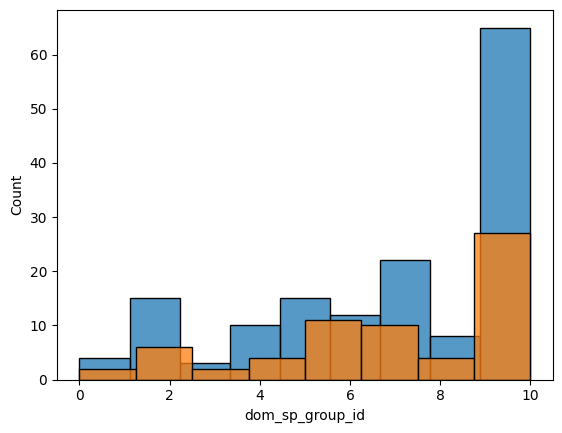

Accuracy: 0.59
Kappa: 0.46


<Axes: >

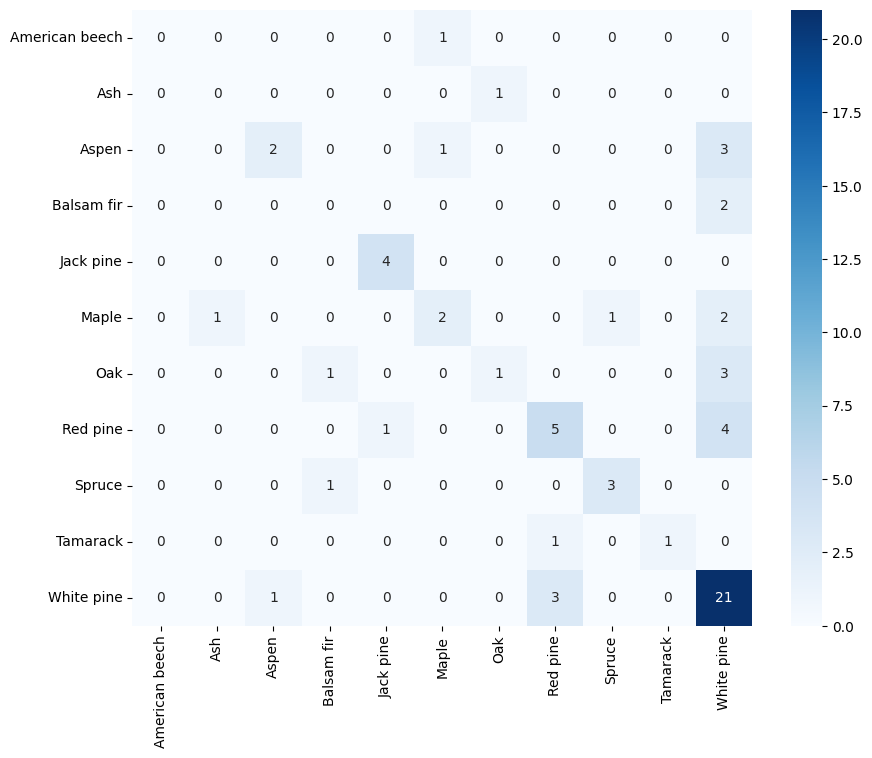

In [25]:
# Train a random forest model to predict dominant species based on predictors

# Use simple train/test split using stratified sampling for now, apply cross-validation later
train_df, test_df =  train_test_split(df[['dom_sp_group_id'] + features_ls],
                 stratify=df['dom_sp_group_id'],
                 test_size=0.3,
                 random_state=25)

# Compare the distribution of dominant species in the training and test sets
sns.histplot(train_df['dom_sp_group_id'])
sns.histplot(test_df['dom_sp_group_id'])
plt.show()

rf = RandomForestClassifier(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['dom_sp_group_id'])

# Apply the model to the test set
test_df['pred_dom_sp_group_id'] = rf.predict(test_df[features_ls])

# Calculate accuracy and kappa
accuracy = accuracy_score(test_df['dom_sp_group_id'], test_df['pred_dom_sp_group_id'])
kappa = cohen_kappa_score(test_df['dom_sp_group_id'], test_df['pred_dom_sp_group_id'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {kappa:.2f}")

# Print confusion matrix

conf_matrix = confusion_matrix(test_df['dom_sp_group_id'], test_df['pred_dom_sp_group_id'])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dom_sp_dict.values(),
            yticklabels=dom_sp_dict.values())

As can be seen in the confusion matrix and classification metrics above, the model performance is not great. It is possible this could be improved somewhat by tuning hyperparameters, curating the datasets, etc.

In this case, we will further simplify the problem to improve our results. Now instead of classifying tree species group, we will simply perform a  classification to determine whether a forest is coniferous (evergreen) vs. deciduous (leafy) dominated, or is mixed.

# Classify Dominant Tree Type (Coniferous/Deciduous)

Group the species in the dataset based on coniferous/deciduous. To determine whether a plot is coniferous/deciduous dominated, we will use a volume threshold of 75%. In other words, if >75% of the plot tree volume is coniferous, it is considered to be a coniferous stand, with the same logic applied to deciduous. If a plot's volume is <75% dominated, it is considered mixed. You can adjust this threshold to see how it affects model performance.

In [26]:
# Let's simplify the problem and just classify whether a plot is broadleaf or deciduous

# Create a dict indicating whether a species is coniferous ('c') or deciduous ('d')
dom_sp_type_dict = {
    'Balsam fir': 'c',
    'White pine': 'c',
    'Red (soft) maple': 'd',
    'Red pine': 'c',
    'Jack pine': 'c',
    'Red oak': 'd',
    'White spruce': 'c',
    'Tamarack': 'c',
    'Sugar Maple': 'd',
    'Trembling Aspen': 'd',
    'Ironwood': 'd',
    'Norway Spruce': 'c',
    'American beech': 'd',
    'Black ash': 'd',
    'White birch': 'd',
    'Largetooth aspen': 'd',
    'Yellow birch': 'd',
    'Basswood': 'd',
    'Northern white cedar': 'c',
    'Eastern hemlock': 'c',
    'White ash': 'd',
    'American elm': 'd',
    'Black cherry': 'd',
    'Balsam poplar': 'd'
}

# Convert to df
sp_type_df = (pd.DataFrame.from_dict(dom_sp_type_dict, columns=['dom_sp_type'], orient='index')
              .reset_index()
              .rename(columns={'index': 'species'}))

# Join with trees
trees_df = trees_df.merge(sp_type_df, on='species', how='left')

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size,tree_id,sp_group,dom_sp_type
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles,1,White pine,c
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles,2,White pine,c
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large,3,Red pine,c
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large,4,Red pine,c
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large,5,White pine,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,NaN,Sugar Maple,N,L,3.7,NaN,NaN,8.893640,0.215043,N,0.000000,0.858564,851.191939,Under,12586,Maple,d
12586,PRF334,NaN,Sugar Maple,N,L,3.3,NaN,NaN,8.500000,0.171060,N,0.000000,0.653868,659.084439,Under,12587,Maple,d
12587,PRF334,NaN,Sugar Maple,N,L,3.2,NaN,NaN,8.395967,0.160850,N,0.000000,0.607493,615.333049,Under,12588,Maple,d
12588,PRF334,NaN,Sugar Maple,N,L,3.0,NaN,NaN,7.400000,0.141372,N,0.000000,0.469656,521.064025,Under,12589,Maple,d


dom_type
c    55.0
m    28.0
d    17.0
Name: count, dtype: float64 0


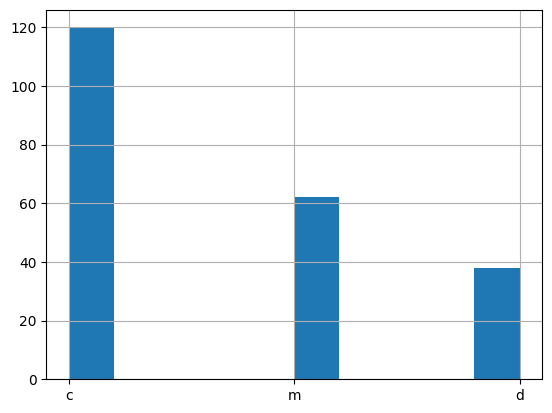

In [27]:

# We will classify a stand as Conifer (c) or Deciduous (d) dominated if the volume of a given type is greater than a specified threshold percentage

CONIF_PERC_THRESH = 75

def calc_conifer_perc(trees):

    conif_df = trees[trees['dom_sp_type'] == 'c'].reset_index(drop=True)

    total_vol = trees['tvol'].sum()

    conif_vol = conif_df['tvol'].sum()

    conif_perc = round(conif_vol / total_vol * 100, 2)

    return(conif_perc)

for plot_nm in df['PlotName']:

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    conif_perc = calc_conifer_perc(trees_i)

    df.loc[df['PlotName'] == plot_nm, 'conif_perc'] = conif_perc


# Classify plots as coniferous (c), deciduous (d), or mixed (m) based on the conifer percentage
def classify_plot_type(conif_perc, conif_perc_thresh):

    if (conif_perc >= conif_perc_thresh):
        return 'c'

    elif conif_perc <= abs(conif_perc_thresh - 100):
        return 'd'

    else:
        return 'm'

df['dom_type'] = df['conif_perc'].apply(lambda x: classify_plot_type(x, CONIF_PERC_THRESH))

# Convert to ordered catopegory
cat_type = CategoricalDtype(categories=['c', 'd', 'm'], ordered=True)

df['dom_type'] = df['dom_type'].astype(cat_type)

# View distribution of dominant types
df['dom_type'].hist()

print(round(df['dom_type'].value_counts() / len(df) * 100), 0)

Accuracy: 0.76
Kappa: 0.59
dom_type
c    36
m    19
d    11
Name: count, dtype: int64


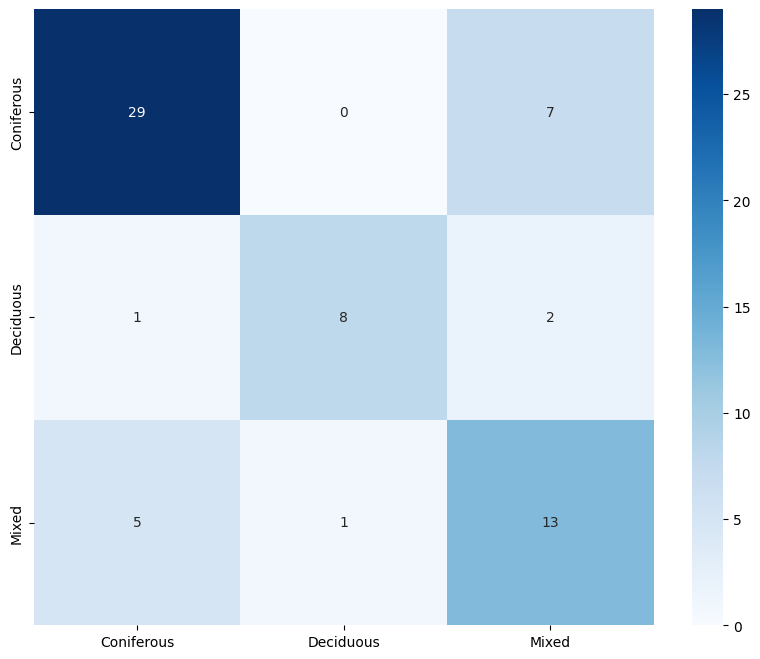

In [28]:
# Train a new random forest model to predict broadleaf vs coniferous

train_df, test_df =  train_test_split(df[['dom_type'] + features_ls],
                 stratify=df['dom_type'],
                 test_size=0.3,
                 random_state=25)

rf = RandomForestClassifier(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['dom_type'])

# Apply the model to the test set
test_df['pred_dom_type'] = rf.predict(test_df[features_ls])

# Calculate accuracy and kappa
accuracy = accuracy_score(test_df['dom_type'], test_df['pred_dom_type'])
kappa = cohen_kappa_score(test_df['dom_type'], test_df['pred_dom_type'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {kappa:.2f}")

# Print confusion matrix

conf_matrix = confusion_matrix(test_df['dom_type'], test_df['pred_dom_type'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Coniferous', 'Deciduous', 'Mixed'],
            yticklabels=['Coniferous', 'Deciduous', 'Mixed'])

print(test_df['dom_type'].value_counts())


**Investigate qualities of plots that were misclassified. Why do you think these plots were misclassified?**

# Regress Conifer Percentage

Classifying a plot as coniferous, deciduous or mixed is simple and effective, however it not capture the nuance of species composition. An interesting approach to machine learning is considering how different modelling objectives can be approached as either classification, or regression problems.

Below we will apply a random forest regressor to estimate coniferous proportion to derive more specific information about species composition in the dataset.

Text(0, 0.5, 'Frequency')

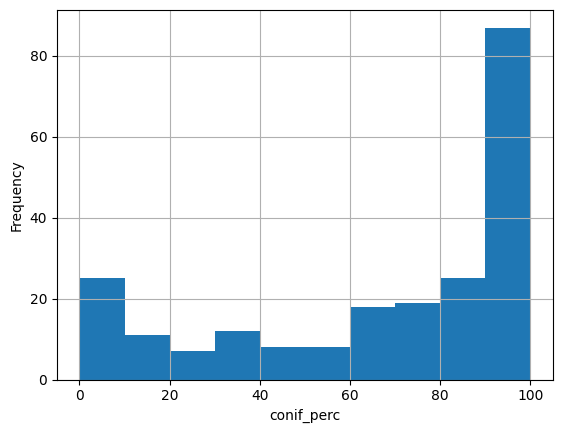

In [31]:
# View conifer percentage
df['conif_perc'].hist()
plt.xlabel('conif_perc')
plt.ylabel('Frequency')

RMSE: 15.26
R^2: 0.77


(0.0, 100.0)

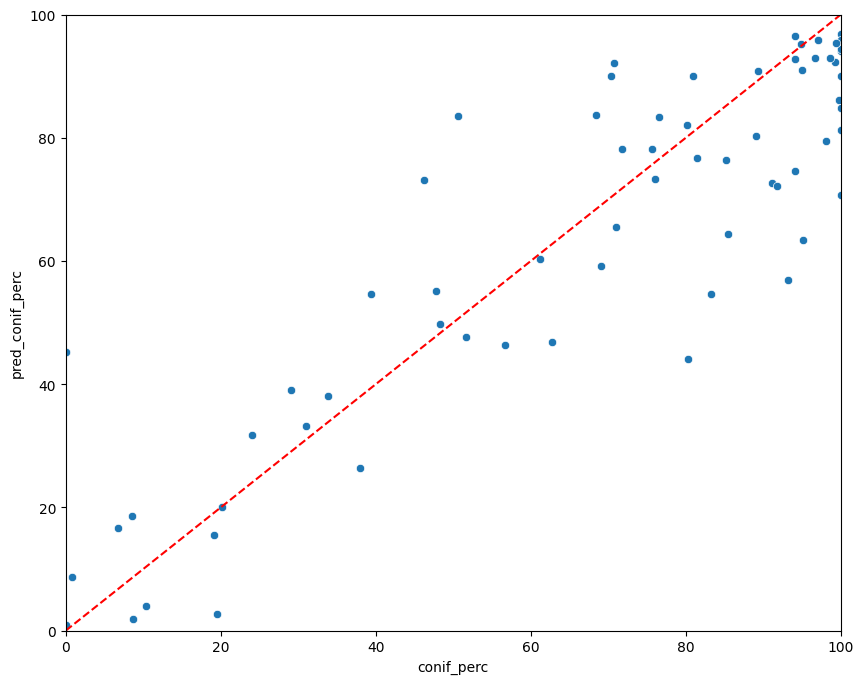

In [32]:

# train a random forest model to predict balsam fir percentage

train_df, test_df =  train_test_split(df[['conif_perc'] + features_ls],
                                        test_size=0.3,
                                        random_state=25)

rf = RandomForestRegressor(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['conif_perc'])

# Apply the model to the test set
test_df['pred_conif_perc'] = rf.predict(test_df[features_ls])

# Calculate regression metrics

rmse = sqrt(mean_squared_error(test_df['conif_perc'], test_df['pred_conif_perc']))
r2 = r2_score(test_df['conif_perc'], test_df['pred_conif_perc'])

print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

# Plot the predicted vs actual values
plt.figure(figsize=(10, 8))
sns.scatterplot(x=test_df['conif_perc'], y=test_df['pred_conif_perc'])
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')

plt.xlim(0, 100)
plt.ylim(0, 100)

Interpret the RMSE, what are the units? What does this represent?

Discuss the difference in performance between classifying dominant tree type (coniferous, deciduous, mixed) versus regressing coniferous prorpotion.


# Perform feature selection using scikit-learn

https://scikit-learn.org/stable/modules/feature_selection.html


# Experiment with different hyperparameters to limit overfitting
